This notebook uses data.x2 (69 features) to do individual sphase prediction.

In [1]:
import data1 as data
import random
from common import *
from rules import *
from realkd.patch import RuleFit
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
import numpy as np
import matplotlib.colors as mcolors


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Individual phase prediction


In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from gam import LogisticGAM

STATE = np.random.RandomState(seed=1000)

lr = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE)

# gams not fixed, remove this part.
gam = LogisticGAM(lam=[12.0]*len(data.x2.columns), max_iter=250)

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)

# Rulefit
rufit = RuleFitWrapper()

indi_estimators = [lr, rf, rufit]
indi_names = ['LR','RanF', 'RuFit']

This following code under "2.6 GHz 6-Core Intel Core i7" runs ~5 hours. You can simply use saved result to re-run the result.

In [4]:
from common import Experiment, LogLikelihoodEvaluator
from sklearn.model_selection import KFold

inter_no_comp = {}

print('')
for y in [data.sphere, data.vesicle, data.worm, data.other]: # miss other
    print('Target: ',y.name)
    experiment = Experiment(indi_estimators, 
                        indi_names,
                        KFold(30, shuffle=True, random_state=STATE),
                        data.x2, y.replace(-1, 0),
                        groups=data.comp_ids.array, 
                        evaluators=['accuracy', LogLikelihoodEvaluator()],
                        verbose=True)
    inter_no_comp[y.name] = experiment.run()
    print()


Target:  sphere
Running experiment with 30 repetitions
******************************

Target:  vesicle
Running experiment with 30 repetitions
******************************

Target:  worm
Running experiment with 30 repetitions
******************************

Target:  other
Running experiment with 30 repetitions
******************************



In [23]:
# import pickle
# with open('interpolation_iid_69.pkl', 'wb') as f:   
#     pickle.dump(inter_no_comp, f)

In [6]:
def plot_summary(metric, summ, num_reps=30, baseline=None, names=None, colors = list(mcolors.BASE_COLORS.keys())):
    width = 0.35
    ind = np.arange(len(summ))
    plt.bar(ind-width/2, summ[f'mean_train_{metric}'], width=width, label='train', 
            yerr=summ[f'std_train_{metric}']/num_reps**0.5, capsize=3.0)
    plt.bar(ind+width/2, summ[f'mean_test_{metric}'], width=width, label='test',
            yerr=summ[f'std_test_{metric}']/num_reps**0.5, capsize=3.0)
    if baseline:
        for i in range(len(baseline)):
            plt.axhline(y=baseline[i], color=colors[i], linestyle='-', label=names[i])
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(ind, summ.index)
    
inter_no_comp_df = {}
for key in inter_no_comp:
    df = inter_no_comp[key].summary()
    df['mean_train_error'] = 1- df['mean_train_accuracy']
    df['std_train_error'] = df['std_train_accuracy']
    df['mean_test_error'] = 1- df['mean_test_accuracy']
    df['std_test_error'] = df['std_test_accuracy']
    inter_no_comp_df[key] = df

In [7]:
# get base line 
# error
informed_error = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = cnt/sum(cnt)
    informed_error.append((1-max(prob)))
print('Informed error: ', informed_error)

uniformed_error = [0.5, 0.5, 0.5, 0.5]
print('Uninformed error: ', uniformed_error)

Informed error:  [0.46283783783783783, 0.2922297297297297, 0.33783783783783783, 0.02533783783783783]
Uninformed error:  [0.5, 0.5, 0.5, 0.5]


In [24]:
change_columns = {"mean_train_log likelihood": 'mean_train_log loss', 
                  'std_train_log likelihood': 'std_train_log loss',
                  'mean_test_log likelihood': 'mean_test_log loss',
                  'std_test_log likelihood': 'std_test_log loss'} # chang log likelihood to log loss

for each in inter_no_comp_df:
    inter_no_comp_df[each] = inter_no_comp_df[each].rename(change_columns, axis=1)
    inter_no_comp_df[each]['mean_train_log loss'] = -1 * inter_no_comp_df[each]['mean_train_log loss']
    inter_no_comp_df[each]['mean_test_log loss'] = -1 * inter_no_comp_df[each]['mean_test_log loss']

In [25]:
inter_no_comp_df['sphere']

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.537162,0.004921,0.537193,0.142011,0.680825,0.001401,0.685333,0.041018,0.462838,0.004921,0.462807,0.142011
RanF,1.000000,0.000000,0.912544,0.073394,0.056800,0.001796,0.283283,0.350926,0.000000,0.000000,0.087456,0.073394
RuFit,0.983166,0.003390,0.917193,0.060219,0.076944,0.004397,0.237952,0.156147,0.016834,0.003390,0.082807,0.060219


In [26]:
inter_no_comp_df['vesicle']

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.707770,0.003560,0.707544,0.103307,0.596987,0.003042,0.599935,0.088084,0.292230,0.003560,0.292456,0.103307
RanF,1.000000,0.000000,0.925526,0.059458,0.049419,0.001104,0.188003,0.088390,0.000000,0.000000,0.074474,0.059458
RuFit,0.989574,0.002847,0.917105,0.050854,0.063493,0.002371,0.185677,0.095077,0.010426,0.002847,0.082895,0.050854


In [27]:
inter_no_comp_df['worm']

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.633911,0.009928,0.630263,0.106332,0.580561,0.002775,0.583295,0.079707,0.366089,0.009928,0.369737,0.106332
RanF,1.000000,0.000000,0.917281,0.056844,0.053729,0.001619,0.253760,0.336384,0.000000,0.000000,0.082719,0.056844
RuFit,0.988875,0.003387,0.905351,0.063164,0.071262,0.003421,0.223164,0.132311,0.011125,0.003387,0.094649,0.063164


In [28]:
inter_no_comp_df['other']

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.974662,0.001276,0.974737,0.036749,0.157774,0.005536,0.162524,0.166690,0.025338,0.001276,0.025263,0.036749
RanF,1.000000,0.000000,0.981579,0.030844,0.010783,0.000781,0.150334,0.456164,0.000000,0.000000,0.018421,0.030844
RuFit,0.995399,0.001804,0.979912,0.036277,0.022120,0.001515,0.067360,0.131713,0.004601,0.001804,0.020088,0.036277


sphere 



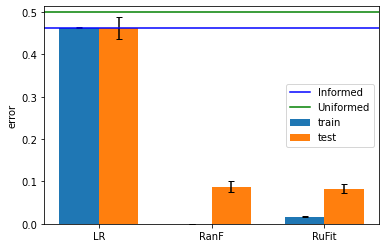

vesicle 



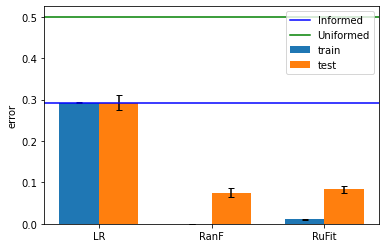

worm 



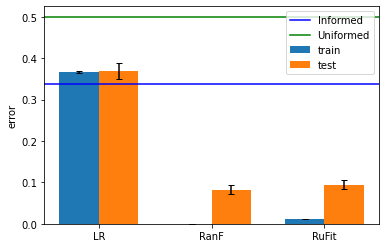

other 



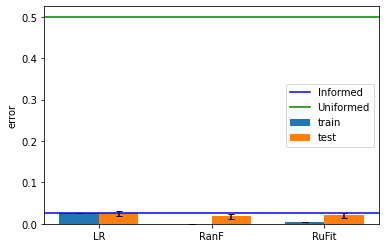

In [29]:
i = 0
for key in inter_no_comp_df:
    print(key, '\n')
    line = [informed_error[i], uniformed_error[i]]
    plot_summary('error', summ=inter_no_comp_df[key], baseline=line, names=['Informed', 'Uniformed'])
    i += 1
    plt.show()

__Log likelihood__

All the estimators performs much better than random guessing and informed guessing.

In [32]:
# get base line 
# log loss
informed_loglikelihood = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = cnt/sum(cnt)
    informed_loglikelihood.append(sum(-1*prob * np.log2(prob)))
print('Informed loglikelihood: ', informed_loglikelihood)

uniformed_loglikelihood = [-1*0.5 * np.log2(0.5)*2] * 4
print('Uninformed loglikelihood: ', uniformed_loglikelihood)

Informed loglikelihood:  [0.9960115235485287, 0.8715841441742509, 0.9227346209530941, 0.17044317741514714]
Uninformed loglikelihood:  [1.0, 1.0, 1.0, 1.0]


sphere 



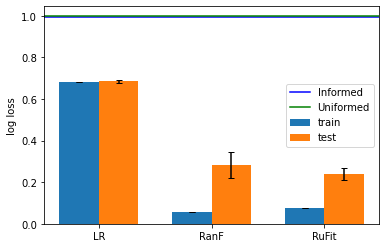

vesicle 



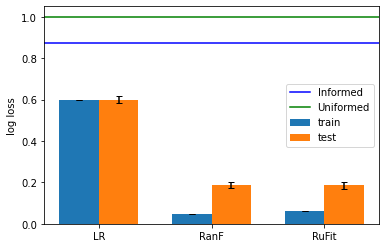

worm 



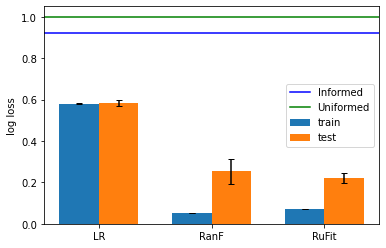

other 



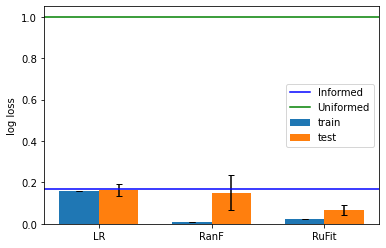

In [34]:
i = 0
for key in inter_no_comp_df:
    print(key, '\n')
    line = [informed_loglikelihood[i], uniformed_loglikelihood[i]]
    plot_summary('log loss', summ=inter_no_comp_df[key], baseline=line, names=['Informed', 'Uniformed'])
    i += 1
    plt.show()

In [ ]:
import pickle
with open('interpolation_iid_69.pkl', 'wb') as f:   
    pickle.dump(inter_no_comp, f)

In [16]:
def loss(y_test, y_pred):
    y_test = y_test.astype(np.float16)
    y_pred = y_pred.astype(np.float16)
    if len(y_test.shape) == 1:
        N = y_test.shape[0]
        loss = 0
        for i in range(N):
            loss -= ((y_test[i]*np.log(y_pred[i]))+((1.0-y_test[i])*np.log(1.0-y_pred[i])))
            loss = loss/N
    else:
        N,M = y_test.shape
        a=[]
        for m in range(M):
            loss=0
            for i in range(N):
                subloss = ((y_test[i,m]*np.log(y_pred[i,m]))+((1.0-y_test[i,m])*np.log(1.0-y_pred[i,m])))
                if np.isnan(subloss):
                    continue
                loss -= subloss
            loss = loss/N
            a.append(round(loss,8))
        loss = np.mean(a)
    return loss

In [20]:
# choose the best RuleFit
best_rf = {}
for phase in inter_no_comp:
    lst = []
    for each in inter_no_comp[phase].fitted_['RuFit']:
        pred = each.predict_proba(data.x2)
        res = log_loss(data.y[phase].values, pred)
        lst.append((res, each))
    lst.sort()
    best_rf[phase] = lst[0][1]

In [22]:
for each in best_rf:
    dic = best_rf[each].get_rules(data.x, data.y[each])
    for key, values in dic.items():
        name = 'Rules/Individual_Phase/Interpolation/69p'+ "_" + key + '.csv'
        values.to_csv(name, index=False)